In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [45]:
df = pd.read_csv("../../data/AmesHousing.csv")
df.head()
df = df.select_dtypes(include="number")
df.dropna(inplace=True)
df["random_feature"] = np.random.random(df.shape[0])
df["Overall Qual Noise"] = df["Overall Qual"] + (df["random_feature"] * 0.0001)
# Split the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(df.drop("SalePrice", axis=1), df["SalePrice"], test_size=test_size, random_state=42)


In [46]:
from sklearn.ensemble import RandomForestRegressor
# Initialize and train a Gradient Boosting Regressor
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [64]:
# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

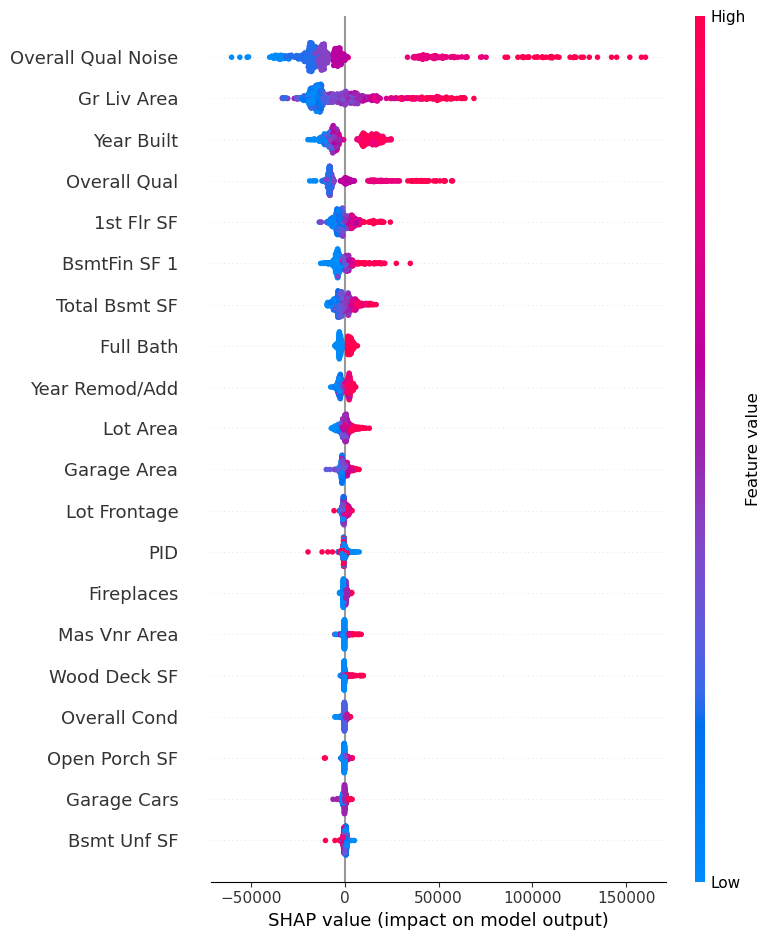

In [67]:
shap.summary_plot(shap_values)

In [51]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

0.1088324353288636

In [60]:
# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [68]:
# Compute the correlation matrix of SHAP values
shap_corr_matrix = pd.DataFrame(shap_values.values, columns=X_test.columns).corr()

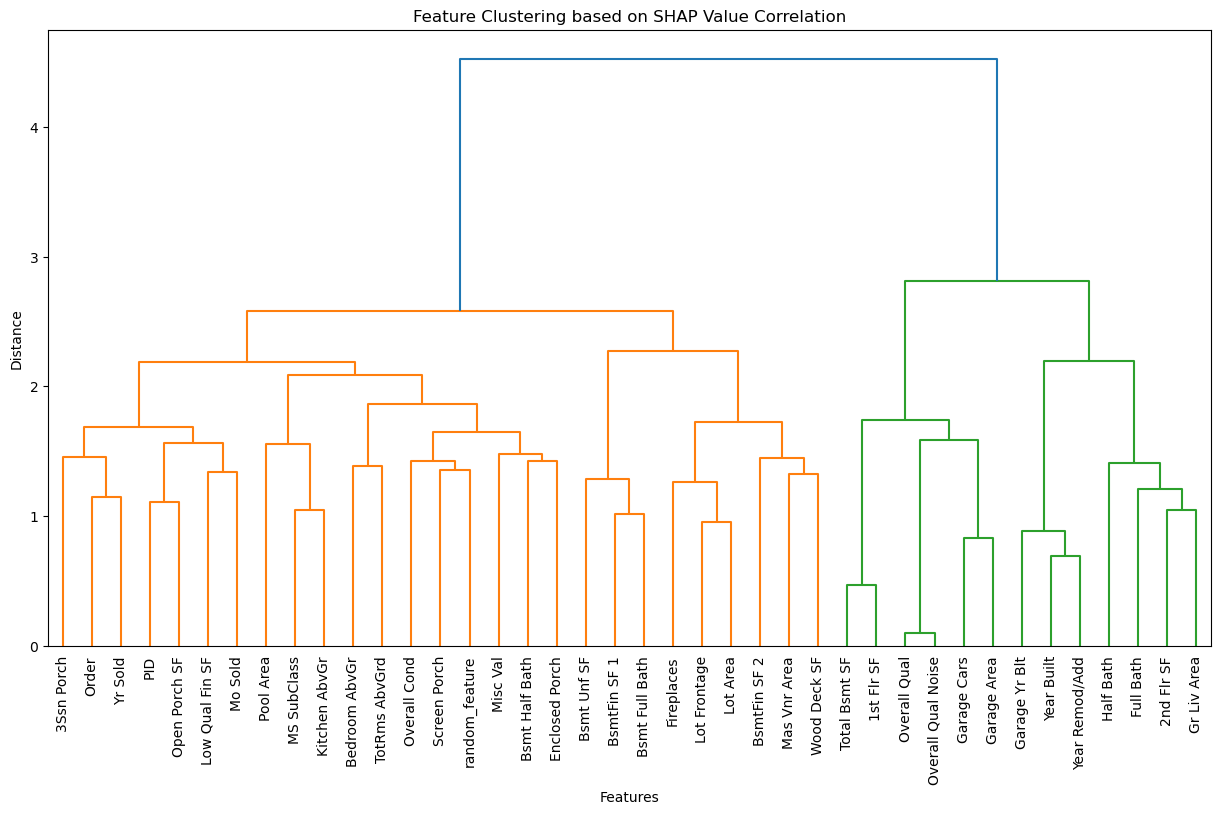

In [74]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming 'shap_corr_matrix' is already computed and ready to use
linked = linkage(shap_corr_matrix, 'ward')

# Create a larger figure for the dendrogram
plt.figure(figsize=(15, 8))  # Adjust the size as needed
# Capture the output by assigning it to a variable
dendro = dendrogram(linked, labels=shap_corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Feature Clustering based on SHAP Value Correlation")
plt.xlabel("Features")
plt.ylabel("Distance")

# Show the plot without printing the dendrogram data structure
plt.show()

In [79]:

# Determine clusters (set threshold for clustering)
cluster_labels = fcluster(linked, t=1.1, criterion='distance')

# Map features to their clusters
feature_clusters = {label: [] for label in set(cluster_labels)}
for feature, label in zip(X_train.columns, cluster_labels):
    feature_clusters[label].append(feature)


In [80]:
feature_clusters

{1: ['Order'],
 2: ['Yr Sold'],
 3: ['3Ssn Porch'],
 4: ['PID'],
 5: ['Open Porch SF'],
 6: ['Low Qual Fin SF'],
 7: ['Mo Sold'],
 8: ['MS SubClass', 'Kitchen AbvGr'],
 9: ['Pool Area'],
 10: ['Bedroom AbvGr'],
 11: ['TotRms AbvGrd'],
 12: ['Screen Porch'],
 13: ['random_feature'],
 14: ['Overall Cond'],
 15: ['Bsmt Half Bath'],
 16: ['Enclosed Porch'],
 17: ['Misc Val'],
 18: ['BsmtFin SF 1', 'Bsmt Full Bath'],
 19: ['Bsmt Unf SF'],
 20: ['Lot Frontage', 'Lot Area'],
 21: ['Fireplaces'],
 22: ['Mas Vnr Area'],
 23: ['Wood Deck SF'],
 24: ['BsmtFin SF 2'],
 25: ['Total Bsmt SF', '1st Flr SF'],
 26: ['Overall Qual', 'Overall Qual Noise'],
 27: ['Garage Cars', 'Garage Area'],
 28: ['Year Built', 'Year Remod/Add', 'Garage Yr Blt'],
 29: ['2nd Flr SF', 'Gr Liv Area'],
 30: ['Full Bath'],
 31: ['Half Bath']}

In [88]:
feature_groups = []
for cluster in feature_clusters.values():
    if len(cluster) == 1:
        feature_groups += cluster
    else:
        group_name = " & ".join(cluster)
        feature_groups.append((group_name, cluster))

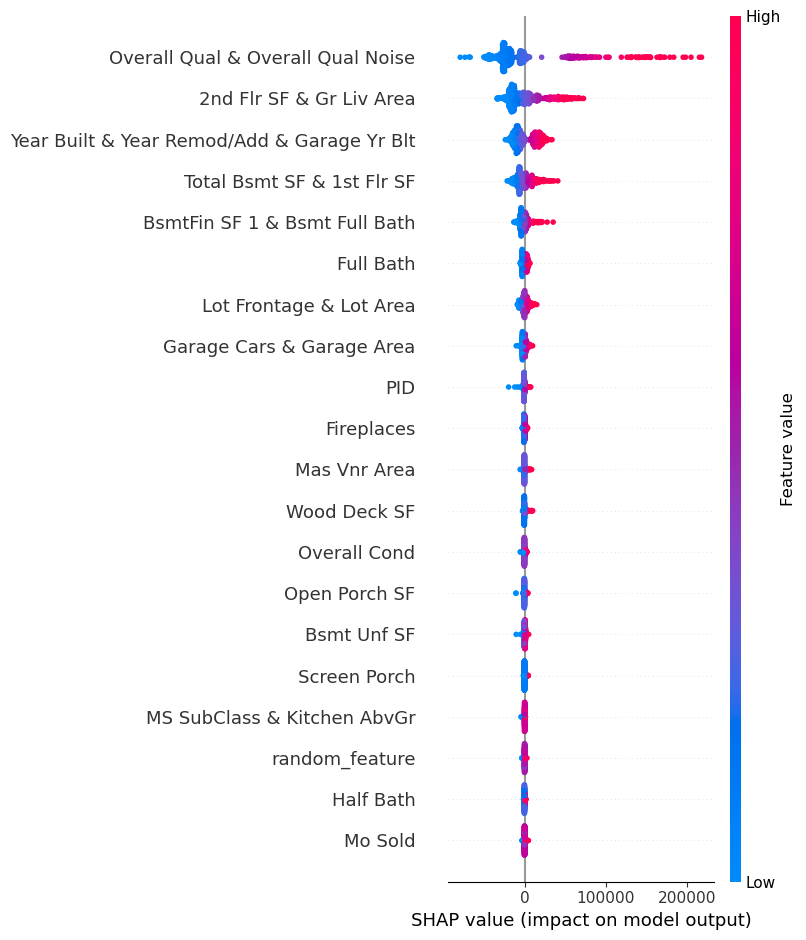

In [89]:
# Function to aggregate SHAP values based on groups
def aggregate_shap_values(shap_values, feature_groups, feature_names):
    # Create a new SHAP values array
    new_shap_values = np.zeros((shap_values.shape[0], len(feature_groups)))
    new_feature_names = []
    
    for i, group in enumerate(feature_groups):
        if isinstance(group, tuple):
            group_name, features = group
            idxs = [feature_names.index(feat) for feat in features]
            new_shap_values[:, i] = shap_values[:, idxs].sum(axis=1)
            new_feature_names.append(group_name)
        else:
            idx = feature_names.index(group)
            new_shap_values[:, i] = shap_values[:, idx]
            new_feature_names.append(group)
    
    return new_shap_values, new_feature_names

# Aggregate SHAP values
new_shap_values, new_feature_names = aggregate_shap_values(shap_values.values, feature_groups, X_test.columns.tolist())

# Create a DataFrame for visualization
visual_data = pd.DataFrame(new_shap_values, columns=new_feature_names)

# Visualize aggregated SHAP values
shap.summary_plot(new_shap_values, visual_data)